In [1]:
from fastai.vision import *
from sklearn.model_selection import train_test_split

from fastai_bayesian.custom_dropout import CustomDropout, switch_custom_dropout, convert_layers, DropLinear
from fastai_bayesian.metrics import (entropy, BALD, uncertainty_best_probability,
                      get_preds_sample, plot_hist_groups, top_k_uncertainty)
from fastai_bayesian.active_learn import ImageActiveLearner

In [18]:
n_in = test.W.in_features
n_out = test.W.out_features
dp = test.dropout.dp

In [31]:
n_sample = 10
p = 1 - dp
margin = 0.05
total_margin = p + margin
new_p = total_margin

k = int(total_margin * n_out)
masks = []

for i in range(n_sample):
    mask = test.topk_sample(n_out,k,new_p)
    mask = mask[None]
    masks.append(mask)

torch.clamp(torch.cat(masks).sum(dim=0),0,1).mean()

tensor(0.3457)

In [28]:
model = learn.model

n_sample = 100

masks = []

for i in range(n_sample):

    mask = topk_sample_model(model)
    mask = torch.cat(mask)
    masks.append(mask)

In [29]:
torch.clamp(torch.stack(masks).sum(dim=0),0,1).mean()

tensor(0.3496)

In [38]:
mask = get_mask_preds(learn,topk_sample_model)

In [42]:
mask,_ = get_mask_preds(learn,topk_sample_model)

In [34]:
mask = topk_sample_model(learn.model)

In [56]:
n_sample = 3

sample_model_fn = partial(topk_sample_model,margin=0.1)
masks = []

for t in range(n_sample):
    mask,pred = get_mask_preds(learn,sample_model_fn=sample_model_fn,activ=activ)
    mask = torch.cat(mask)
    masks.append(mask)

In [57]:
torch.clamp(torch.stack(masks).sum(dim=0),0,1).mean()

tensor(0.3939)

In [49]:
model = learn.model

n_sample = 3
masks = []

for i in range(n_sample):
    mask,_ = get_mask_preds(learn,topk_sample_model)
    mask = torch.cat(mask)
    masks.append(mask)

In [50]:
torch.clamp(torch.stack(masks).sum(dim=0),0,1).mean()

tensor(0.3496)

In [112]:
def get_model(dp):
    model = nn.Sequential(
        nn.Flatten(),
        DropLinear(784,512,dp=dp),
        nn.ReLU(),
        DropLinear(512,512,dp=dp),
        nn.ReLU(),
        DropLinear(512,512,dp=dp),
        nn.ReLU(),
        nn.Linear(512,10)
    )
    return model

In [3]:
def train_test_split_image(train_size):
    # Create two data bunchs, one for training the unsupervised model, one for testing
    # the results of the semi supervised model
    
    # We first load the whole data set 
    path = untar_data(URLs.MNIST)
    tfms = get_transforms(do_flip = False)
    data = (ImageList.from_folder(path/"training")
            .split_none()
            .label_from_folder()
            .transform()
            .databunch())

    # We then randomly select train_size samples from the whole MNIST and put in train
    # for the unsupervised, and semi supervised training, and the rest will be used 
    # as a test set for the semi supervised model evaluation
    
    n = len(data.train_ds.x.items)
    
    # We create two data frames which will be used to create the data bunches
    train_idx = np.random.choice(n,train_size,replace = False)
    x_train,y_train = data.train_ds.x.items[train_idx],data.train_ds.y.items[train_idx]
    train_df = pd.DataFrame({"name":x_train,"label":y_train})
    
    test_idx = np.array(list(set(np.arange(n)) - set(train_idx)))
    x_test,y_test = data.train_ds.x.items[test_idx],data.train_ds.y.items[test_idx]
    test_df = pd.DataFrame({"name" : x_test,"label":y_test})
    
    return train_df, test_df

In [4]:
path = untar_data(URLs.MNIST)

In [5]:
total_train_size = 50000

train_df, test_df = train_test_split_image(total_train_size)

In [6]:
data = ImageActiveLearner.create_databunch(train_df,bs=512)

In [113]:
model = get_model(dp=0.5)
learn = Learner(data,model,metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


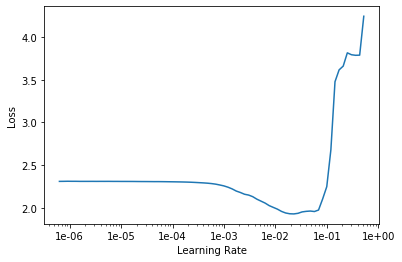

In [106]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20,1e-2/2)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10,1e-3)

In [99]:
learn.save("model_dp_70")

In [9]:
learn.load("model_dp_70")

Learner(data=ImageDataBunch;

Train: LabelList (40000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,1,3,3,2
Path: /;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
3,8,1,6,2
Path: /;

Test: None, model=Sequential(
  (0): Flatten()
  (1): DropLinear(
    (dropout): CustomDropout(dp=0.7, activate_stochasticity=True)
    (W): Linear(in_features=784, out_features=512, bias=True)
  )
  (2): ReLU()
  (3): DropLinear(
    (dropout): CustomDropout(dp=0.7, activate_stochasticity=True)
    (W): Linear(in_features=512, out_features=512, bias=True)
  )
  (4): ReLU()
  (5): DropLinear(
    (dropout): CustomDropout(dp=0.7, activate_stochasticity=True)
    (W): Linear(in_features=512, out_features=512, bias=True)
  )
  (6): ReLU()
  (7): Linear(in_features=512, out_features=10, bias=True)
), opt_func=functools.partial

In [109]:
learn.save("model_dp_50")

In [114]:
learn.load("model_dp_50")

Learner(data=ImageDataBunch;

Train: LabelList (40000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
8,1,3,3,2
Path: /;

Valid: LabelList (10000 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
3,8,1,6,2
Path: /;

Test: None, model=Sequential(
  (0): Flatten()
  (1): DropLinear(
    (dropout): CustomDropout(dp=0.5, activate_stochasticity=True)
    (W): Linear(in_features=784, out_features=512, bias=True)
  )
  (2): ReLU()
  (3): DropLinear(
    (dropout): CustomDropout(dp=0.5, activate_stochasticity=True)
    (W): Linear(in_features=512, out_features=512, bias=True)
  )
  (4): ReLU()
  (5): DropLinear(
    (dropout): CustomDropout(dp=0.5, activate_stochasticity=True)
    (W): Linear(in_features=512, out_features=512, bias=True)
  )
  (6): ReLU()
  (7): Linear(in_features=512, out_features=10, bias=True)
), opt_func=functools.partial

In [115]:
preds,y = get_preds_sample(learn)
pred = preds.mean(dim=0)
accuracy(pred,y)

tensor(0.9877)

In [70]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity,self).__init__()
        
    def forward(self,x):
        return x

def topk_sample_model(model,margin=0.05,set_mask=True):
    """Sample a mask for each Droplinear and set it
    
    Args:
        model: nn.Module
        
    Returns:
        masks: List of tensor masks
    """
    masks = []
    for m in model:
        if isinstance(m,DropLinear):
            dp = m.dropout.dp
            p = 1-dp
            
            upper_p = p + margin
            scaled_p = p / (p + margin)

            n = m.W.weight.data.shape[0]
            k = int(upper_p * n)

            mask = m.topk_sample(n,k,scaled_p)
            if set_mask:
                m.set_mask(mask) 
            masks.append(mask)
    return masks

def sample_model(model,set_mask=True):
    """Sample a mask for each Droplinear and set it"""
    masks = []
    for m in model:
        if isinstance(m,DropLinear):
            mask = m.sample()
            if set_mask:
                m.set_mask(mask) 
            masks.append(mask)
    return masks

def get_mask_preds(learn,sample_model_fn,activ=None,ds_type=DatasetType.Fix):
    """Sample a mask and get preds
    
    Args: 
        learn: A Learner
        sample_model_fn: A function which will sample the weights of the model learner
        activ: A function to call on the outputs of the get_preds
        ds_type:
        
    Returns:
        mask: A list of tensor masks
        pred: A tensor of predictions
    
    """
    mask = sample_model_fn(learn.model)
    pred,y = learn.get_preds(ds_type=ds_type,activ=activ)
    pred = pred.view((1,) + pred.shape)
    return mask,pred

def kls(preds):
    """Return the KL between the overall mean and the means without each mask"""
    mean_pred = torch.cat(preds).mean(dim=0)
    pred = torch.cat(preds)
    means_pred = (mean_pred[None] * T - pred)/ (T-1)

    logs = torch.log(mean_pred[None] / means_pred)

    kls = torch.einsum("tic,ic -> t",logs,mean_pred)
    
    return kls    

def MC_cross_entropy(logits,target):
    """Computes the MC cross entropy"""
    T = logits.shape[0]
    
    normalized_logits = logits - torch.logsumexp(logits,dim=2,keepdim=True)
    log_prob = torch.logsumexp(normalized_logits,dim=0) - torch.log(torch.tensor(T).float())

    target = target[:,None]
    cross_entropy = (-torch.gather(log_prob,1,y[:,None])).mean()

    return cross_entropy

def MC_entropy(x_logits):
    
    return MC_cross_entropy(x_logits,x_logits)

def MC_kl(x_logits,y_logits):
    cross_entropy = MC_cross_entropy(x_logits,y_logits)
    entropy = MC_entropy(x_logits)
    
    kl = cross_entropy - entropy
    
    return kl

In [72]:
from neptune.sessions import Session
import getpass

api_token = getpass.getpass("Please enter your NeptuneML API token : ")
session = Session(api_token=api_token)
project = session.get_project(project_qualified_name='danywin/EnsembleDropout')

Please enter your NeptuneML API token : ········


'model_dp_50'

In [127]:
T = 10
n_steps = 100
activ = Identity()

margin = 0.05
# sample_model_fn = partial(topk_sample_model,margin=margin)
sample_model_fn = sample_model

dp=0.5
model_name = f"model_dp_{int(dp*100)}"

model = get_model(dp=dp)
learn = Learner(data,model,metrics=accuracy)
learn = learn.load(model_name)

p,y = get_preds_sample(learn,DatasetType.Fix,n_sample=T)
p = p.mean(dim=0)
inital_score = accuracy(p,y).item()

masks = []
preds = []

for t in range(T):
    mask,pred = get_mask_preds(learn,sample_model_fn=sample_model_fn,activ=activ)
    mask = torch.cat(mask)
    masks.append(mask)
    preds.append(pred)
    
initial_coverage = torch.clamp(torch.stack(masks,dim=1).sum(dim=1),0,1).mean().item()

params = {"T":T,"n_steps":n_steps,"activ":str(activ),"sample_model_fn":str(sample_model_fn),
         "model_name":model_name,"initial_score":inital_score,"initial_coverage":initial_coverage}

exp_name = model_name + "_" + str(sample_model_fn)

In [128]:
params

{'T': 10,
 'n_steps': 100,
 'activ': 'Identity()',
 'sample_model_fn': '<function sample_model at 0x7f6c4b9255f0>',
 'model_name': 'model_dp_50',
 'initial_score': 0.9865000247955322,
 'initial_coverage': 0.9967448115348816}

In [129]:
logits = torch.cat(preds)

current_ce = MC_cross_entropy(logits,y)

In [ ]:
with project.create_experiment(name=exp_name,params=params) as exp:

    for i in range(n_steps):

        candidate_mask, candidate_pred = get_mask_preds(learn,sample_model_fn=sample_model_fn,activ=activ)
        candidate_mask = torch.cat(candidate_mask)

        candidate_ce = []

        for t in range(T):
            # We remove the current and add the candidate
            pool = preds.copy()
            del pool[t]
            pool.append(candidate_pred)

            logits = torch.cat(pool)
            ce = MC_cross_entropy(logits,y)
            candidate_ce.append(ce)

        candidate_ce = torch.stack(candidate_ce)

        difference_ce = candidate_ce - current_ce
        min_ce,argmin_ce = difference_ce.min().item(), difference_ce.argmin().item()

        if min_ce < 0:

            del preds[argmin_ce]
            del masks[argmin_ce]

            preds.append(candidate_pred)
            masks.append(candidate_mask)

            current_ce = candidate_ce.min().item()

            p = torch.cat(preds).mean(dim=0)
            score = accuracy(p,y)

            exp.send_metric("ce",current_ce)
            exp.send_metric("score",score.item())
            exp.send_metric("changes",i)
            exp.send_metric("max_diff",np.abs(min_ce))

            #             output = {"min":, "max":current_kl.max().item(),
            #                       "mean":current_kl.mean().item(),"std":current_kl.std().item(),"score":score}
            #             outputs.append(output)
    
    final_coverage = torch.clamp(torch.stack(masks,dim=1).sum(dim=1),0,1).mean()
    exp.send_metric("final_coverage",final_coverage)

tensor(0.5996)

In [61]:
# x_logits = torch.cat(preds)

# current_kl = []
# for t in range(T):
#     y = preds.copy()
#     del y[t]
#     y_logits = torch.cat(y)
#     kl = MC_kl(x_logits,y_logits)
#     current_kl.append(kl)
    
# current_kl = torch.stack(current_kl)

In [ ]:
changes = []

with project.create_experiment(name=exp_name,params=params) as exp:

    for i in range(n_steps):

        candidate_mask, candidate_pred = get_mask_preds(learn,sample_model_fn=sample_model_fn,activ=activ)
        candidate_mask = torch.cat(candidate_mask)

        candidate_kl = []
        for t in range(T):
            pool = preds.copy()
            del pool[t]

            y_logits = torch.cat(pool)

            pool.append(candidate_pred)
            x_logits = torch.cat(pool)

            kl = MC_kl(x_logits,y_logits)
            candidate_kl.append(kl)

        candidate_kl = torch.stack(candidate_kl)

        difference_kl = current_kl - candidate_kl
        min_kl,argmin_kl = difference_kl.min().item(), difference_kl.argmin().item()

        if min_kl < 0:

            del preds[argmin_kl]
            del masks[argmin_kl]

            preds.append(candidate_pred)
            masks.append(candidate_mask)

            current_kl = candidate_kl

            p = torch.cat(preds).mean(dim=0)
            score = accuracy(p,y)
            
            exp.send_metric("min",current_kl.min().item())
            exp.send_metric("max",current_kl.max().item())
            exp.send_metric("mean",current_kl.mean().item())
            exp.send_metric("std",current_kl.std().item())
            exp.send_metric("score",score.item())
            exp.send_metric("changes",i)
            exp.send_metric("max_diff",np.abs(min_kl) )

#             output = {"min":, "max":current_kl.max().item(),
#                       "mean":current_kl.mean().item(),"std":current_kl.std().item(),"score":score}
#             outputs.append(output)

            changes.append(i)
    
    final_coverage = torch.clamp(torch.cat(masks,dim=1).sum(dim=1),0,1).mean().item()
    exp.send_metric("final_coverage",final_coverage)

In [163]:
changes

[0, 1, 2, 29, 30, 32]

In [164]:
df.score

0    tensor(0.9396)
1    tensor(0.9405)
2    tensor(0.9409)
3    tensor(0.9401)
4    tensor(0.9400)
Name: score, dtype: object

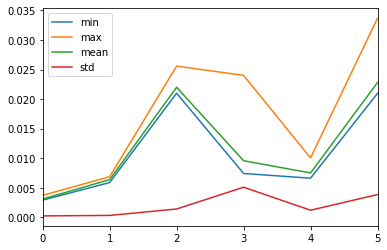

In [165]:
df = pd.DataFrame(outputs)
df.plot()

In [ ]:
for t in range(T):
    

In [61]:
output

[tensor(0.0003),
 tensor(0.0001),
 tensor(0.0002),
 tensor(0.0003),
 tensor(0.0002),
 tensor(0.0001),
 tensor(9.0346e-05),
 tensor(9.6604e-05),
 tensor(0.0009),
 tensor(0.0003)]

In [46]:
x_logits = torch.cat(preds)

i = 0
y = preds.copy()
del y[i]
y_logits = torch.cat(y)

In [57]:
MC_KL(x_logits,y_logits)

tensor(0.0242)

In [33]:
mask,_ = get_mask_preds(learn)
mask = torch.cat(mask)

In [42]:
u = torch.clamp(masks + mask,0,1).sum(dim=0)

In [43]:
i = (mask * masks).sum(dim=0)

In [48]:
i / u

tensor([0.4085, 0.4116, 0.4034, 0.3728, 0.4077])

In [34]:
masks = 

In [116]:
T = 10
mean = []
low = []
high = []
std = []

masks = []
preds = []
for t in range(T):
    mask,pred = get_mask_preds(learn,sample_model,ds_type=DatasetType.Fix)
    masks.append(mask)
    preds.append(pred)

In [117]:
kls(preds)

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [118]:
pred = torch.cat(preds)

In [123]:
n = 10000
pred = pred[:,:n,:]

In [130]:
mean_pred = pred.mean(dim=0,keepdim=True).expand(20,-1,-1)

In [158]:
x,y = data.one_batch()

for tfm in data.train_dl.tfms:
    x,y = tfm((x,y))
    

In [159]:
learn.model(x.cuda())

tensor([[ -3.8175,   5.3751,  -3.9777,  ...,  -3.7914,   5.6218,  -3.7429],
        [ 18.9034, -34.1240,  -5.1276,  ..., -24.8360,  -8.2155,  -0.3190],
        [-15.3342,  -6.2214,   1.4194,  ..., -17.0330,   2.5861,  -8.9764],
        ...,
        [  9.1765, -21.6155,  -2.8188,  ..., -10.4872,  -2.3215,   2.4392],
        [-15.7081,  -3.8299,  11.2177,  ...,  -1.8643,  -4.3008, -12.5930],
        [-23.8934, -10.1384,  -3.4591,  ...,  -7.4998,   2.7617,   3.9378]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [129]:
mean_pred * torch.log(mean_pred/diff)

torch.Size([20, 10000, 10])

In [32]:
def kl(ref_distribution,list_distributions):
    """Vectorized KL divergence between one distribution and a list of distributions
    
    Args:
        ref_distribution: A 1*N*C tensor with 
        list_distributions: A T*N*C tensor
        
    Returns:
    """
    
    log_ratio = torch.log(ref_distribution/list_distributions)
    
    prod = 
    
    kls = torch.einsum("tic,ic -> t",log_ratio,ref_distribution.squeeze(0))
    
    return kls

In [36]:
pred.shape

torch.Size([10, 40000, 10])

In [135]:
s = pred.sum(dim=0,keepdim=True).expand(T,-1,-1)

In [139]:
m = s / T

In [140]:
modified_m = (s - pred) / (T-1)

In [210]:
p_raws = []
T = 3

for t in range(T):
    p_raw,y = learn.get_preds(activ=activ)
    p_raw = p_raw[None]
    p_raws.append(p_raw)

In [ ]:
def MC_cross_entropy()

In [213]:
p_raws = torch.cat(p_raws)

In [218]:
logits_diff = p_raws - torch.logsumexp(p_raws,dim=2,keepdim=True)

In [224]:
log_mean_prob = torch.logsumexp(logits_diff,dim=0) - torch.log(torch.tensor(T).float())

In [228]:
mean_prob = torch.softmax(p_raws,dim=2).mean(dim=0)

In [229]:
(-mean_prob * log_mean_prob).sum()

tensor(1390.4841)

In [194]:
p = torch.softmax(p_raw,dim=1)

In [199]:
log_p = (p_raw - torch.logsumexp(p_raw,dim=1,keepdim=True))

In [208]:
F.log_softmax(p_raw,dim=1)

tensor([[-3.6759e+01, -2.8045e+01, -1.0623e+01,  ..., -2.7299e-05,
         -2.1733e+01, -1.3016e+01],
        [-1.0951e+01, -1.0318e+01, -3.1483e-01,  ..., -1.1896e+01,
         -1.3211e+00, -1.1653e+01],
        [-4.5585e+01, -1.8006e+01, -1.4096e+01,  ..., -1.8132e+01,
         -1.0083e+01, -1.5164e+01],
        ...,
        [-1.2989e+01, -1.8348e+01, -1.4768e+01,  ..., -8.6368e+00,
         -4.6091e+00, -1.0719e-02],
        [-2.6172e+01, -2.5133e+01, -2.5033e+01,  ..., -3.4497e+01,
          0.0000e+00, -3.0120e+01],
        [-3.3970e+01, -4.8533e+01, -4.0298e+01,  ..., -4.2024e+01,
         -2.3046e+01, -1.7140e+01]])

In [201]:
log_p.

tensor(-208.3708)

In [168]:
p = learn.model(x.cuda())

In [182]:
activ = Identity()

In [178]:
torch.softmax(p,dim=1)

tensor(0., device='cuda:0', grad_fn=<MinBackward1>)

In [145]:
(torch.log(m/modified_m) * m).sum(dim=2).max()

tensor(nan)

In [154]:
pred[0,0,:]

tensor(1.0000)

In [80]:
(torch.log(m / diff) * m).sum(dim=(2))

tensor([     inf,      inf,      inf,      inf,      inf,      inf,      inf,
             inf,      inf, 125.0027])

In [69]:
pred = torch.cat(preds).mean(dim=0)
accuracy(pred,y)

tensor(0.9265)

In [68]:
p,y = learn.get_preds(DatasetType.Fix)

In [51]:
for m in learn.model:
    if isinstance(m,DropLinear):
        m.remove_mask()

In [ ]:
n_iterations = 60

for i in range(n_iterations):
    scores = remove_lowest(masks,preds,kls,True)
    mean.append(scores.mean().item())
    low.append(scores.min().item())
    high.append(scores.max().item())
    std.append(scores.std().item())
    
    mask,pred = get_mask_preds(learn)
    masks.append(mask)
    preds.append(pred)

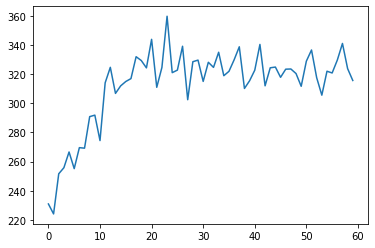

In [454]:
plt.plot(mean)

In [417]:
import itertools

In [457]:
p = torch.cat(preds).mean(dim=0)

In [458]:
accuracy(p,y)

tensor(0.9658)

In [427]:
_,y = learn.get_preds(DatasetType.Fix)

In [429]:
p,y = get_preds_sample(learn,DatasetType.Fix)

In [431]:
p = (p).mean(dim=0)

In [434]:
for m in learn.model:
    if isinstance(m,DropLinear):
        m.remove_mask()

In [437]:
learn.validate(learn.dl(DatasetType.Fix))

[0.12555529, tensor(0.9631)]

In [62]:
total = torch.zeros(1536,1)

for mask in masks:
    total += torch.cat(mask)

total = torch.clamp(total,0,1)

total.mean()

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [395]:
kls

tensor([39.3916, 32.5208, 41.0234, 61.9734, 45.3171, 76.7213, 58.6875, 59.2673,
        30.5528, 55.3150])

In [398]:
del preds[idx]

In [240]:
for tfm in learn.data.train_dl.tfms:
    x,y = tfm((x,y))

In [243]:
learn.model(x)

RuntimeError: Expected object of device type cuda but got device type cpu for argument #2 'mat1' in call to _th_addmm

In [217]:
l = DropLinear(20,10,0.5)

In [184]:
mask = l.sample()

In [185]:
l.set_mask(mask)

In [186]:
mask

tensor([[1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.]])

In [197]:
l.remove_mask()

In [141]:
import types

In [155]:
torch.is_nonzero(None)

TypeError: is_nonzero(): argument 'input' (position 1) must be Tensor, not NoneType

In [152]:
x = torch.randn(20)